### <font color='blue'> Usando SVM Para Prever a Intenção de Compra de Usuários de E-Commerce</font>

## Importando os Pacotes

In [1]:
# Imports
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn import svm
import sklearn
import matplotlib
import warnings
warnings.filterwarnings('ignore')

## Carga e Dicionário de Dados

In [2]:
# Carregando os dados
df_original = pd.read_csv('dados/online_shoppers_intention.csv')
df_original.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


Dicionário de Dados:

"Administrativo", "Duração administrativa", "Informativo", "Duração informativo", "Relacionado ao produto" e "Duração relacionada ao produto" representam o número de diferentes tipos de páginas visitadas pelo visitante nessa sessão e o tempo total gasto em cada uma dessas categorias de página. Os valores desses recursos são derivados das informações de URL das páginas visitadas pelo usuário e atualizadas em tempo real quando um usuário executa uma ação, por exemplo, passando de uma página para outra. 

Os recursos "Taxa de rejeição", "Taxa de saída" e "Valor da página" representam as métricas medidas pelo "Google Analytics" para cada página no site de comércio eletrônico. 

O valor do recurso "Taxa de rejeição" de uma página da web refere-se à porcentagem de visitantes que entram no site a partir dessa página e saem ("rejeição") sem acionar outras solicitações ao servidor durante essa sessão. 

O valor do recurso "Taxa de saída" para uma página da web específica é calculado como a porcentagem que foi a última na sessão, para todas as exibições de página a página. 

O recurso "Valor da página" representa o valor médio para uma página da web que um usuário visitou antes de concluir uma transação de comércio eletrônico. 

O recurso "Dia especial" indica a proximidade do horário de visita do site a um dia especial específico (por exemplo, dia das mães, dia dos namorados) em que as sessões têm mais probabilidade de serem finalizadas com a transação. O valor desse atributo é determinado considerando a dinâmica do comércio eletrônico, como a duração entre a data do pedido e a data de entrega. Por exemplo, no dia dos namorados, esse valor assume um valor diferente de zero entre 2 e 12 de fevereiro (dia dos namorados nos EUA e Europa), zero antes e depois dessa data, a menos que esteja próximo de outro dia especial e seu valor máximo de 1 em 8 de fevereiro. 

O conjunto de dados também inclui o tipo de sistema operacional, navegador, região, tipo de tráfego, tipo de visitante como visitante novo ou recorrente, um valor booleano indicando se a data da visita é final de semana e mês do ano.

A variável alvo (Revenue) é booleana, com True se a sessão gerou receita e False se não gerou.

## Análise Exploratória

In [3]:
# Shape
df_original.shape

(12330, 18)

In [4]:
# Tipos de Dados
df_original.dtypes

Administrative             float64
Administrative_Duration    float64
Informational              float64
Informational_Duration     float64
ProductRelated             float64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

In [5]:
# Verificando valores missing
print(df_original.isna().sum())

Administrative             14
Administrative_Duration    14
Informational              14
Informational_Duration     14
ProductRelated             14
ProductRelated_Duration    14
BounceRates                14
ExitRates                  14
PageValues                  0
SpecialDay                  0
Month                       0
OperatingSystems            0
Browser                     0
Region                      0
TrafficType                 0
VisitorType                 0
Weekend                     0
Revenue                     0
dtype: int64


In [6]:
# Removendo as linhas com valores missing
df_original.dropna(inplace = True)

In [7]:
# Verificando valores missing
print(df_original.isna().sum())

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64


In [8]:
# Shape
df_original.shape

(12316, 18)

In [9]:
# Verificando Valores Únicos
df_original.nunique()

Administrative               27
Administrative_Duration    3336
Informational                17
Informational_Duration     1259
ProductRelated              311
ProductRelated_Duration    9552
BounceRates                1872
ExitRates                  4777
PageValues                 2704
SpecialDay                    6
Month                        10
OperatingSystems              8
Browser                      13
Region                        9
TrafficType                  20
VisitorType                   3
Weekend                       2
Revenue                       2
dtype: int64

Para fins de visualização, dividiremos os dados em variáveis contínuas e categóricas. Trataremos todas as variáveis com menos de 30 entradas únicas como categóricas.

In [10]:
# Preparando os dados para o plot

# Cria uma cópia do dataset original
df = df_original.copy()

# Listas vazias para os resultados
continuous = []
categorical = []

# Loop pelas colunas
for c in df.columns[:-1]:
    if df.nunique()[c] >= 30:
        continuous.append(c)
    else:
        categorical.append(c)

In [11]:
continuous

['Administrative_Duration',
 'Informational_Duration',
 'ProductRelated',
 'ProductRelated_Duration',
 'BounceRates',
 'ExitRates',
 'PageValues']

In [12]:
# Variáveis contínuas
df[continuous].head()

,Administrative_Duration,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues
0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0
1,0.0,0.0,2.0,64.000000,0.00,0.10,0.0
2,-1.0,-1.0,1.0,-1.000000,0.20,0.20,0.0
3,0.0,0.0,2.0,2.666667,0.05,0.14,0.0
4,0.0,0.0,10.0,627.500000,0.02,0.05,0.0


In [13]:
# Variáveis categóricas
df[categorical].head()

,Administrative,Informational,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,0.0,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False
1,0.0,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False
2,0.0,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False
3,0.0,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False
4,0.0,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True


Gráficos para variáveis numéricas.

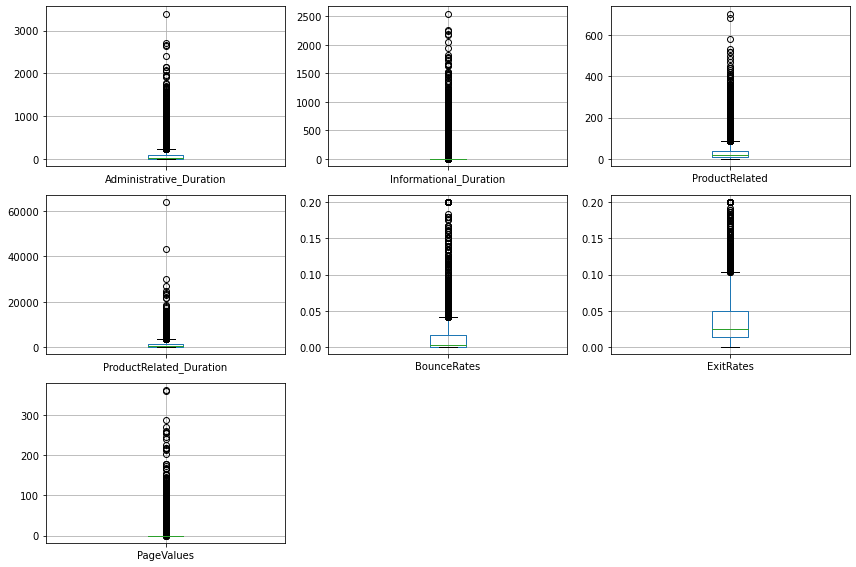

In [14]:
# Plot das variáveis contínuas

# Tamanho da área de plotagem
fig = plt.figure(figsize = (12,8))

# Loop pelas variáveis contínuas
for i, col in enumerate(continuous):
    plt.subplot(3, 3, i + 1);
    df.boxplot(col);
    plt.tight_layout()
    
plt.savefig('imagens/boxplot1.png')

Variáveis contínuas parecem extremamente distorcidas. Vamos aplicar transformação de log para melhor visualização.

In [15]:
# Transformação de log nas variáveis contínuas
df[continuous] = np.log1p(1 + df[continuous])

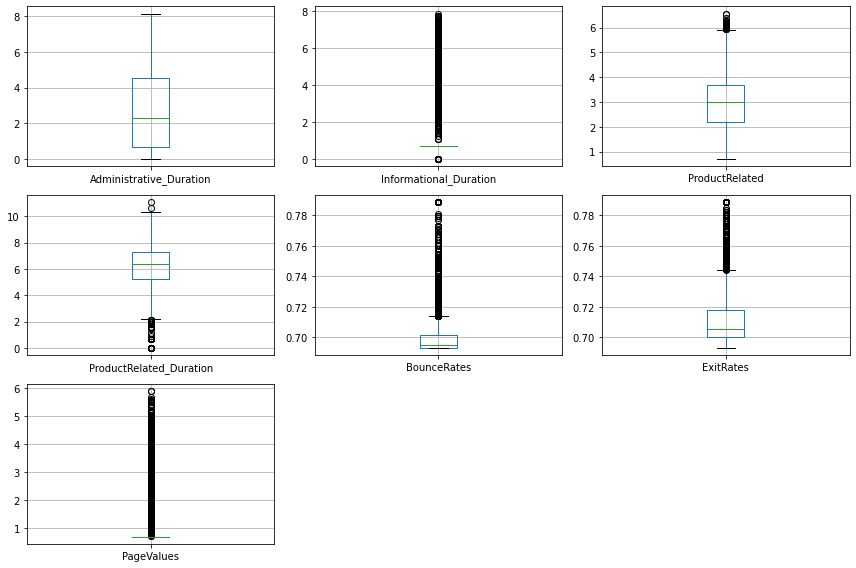

In [16]:
# Plot das variáveis contínuas

# Tamanho da área de plotagem
fig = plt.figure(figsize = (12,8))

# Loop pelas variáveis contínuas
for i,col in enumerate(continuous):
    plt.subplot(3,3,i+1);
    df.boxplot(col);
    plt.tight_layout()
plt.savefig('imagens/boxplot2.png')

# OBS: mesmo assim algumas variaveis nao ficaram muito bem para serem analisadas, talvez seja interessante aplicar a padronização

Matriz de Correlação Entre Variáveis Contínuas.

<AxesSubplot:>

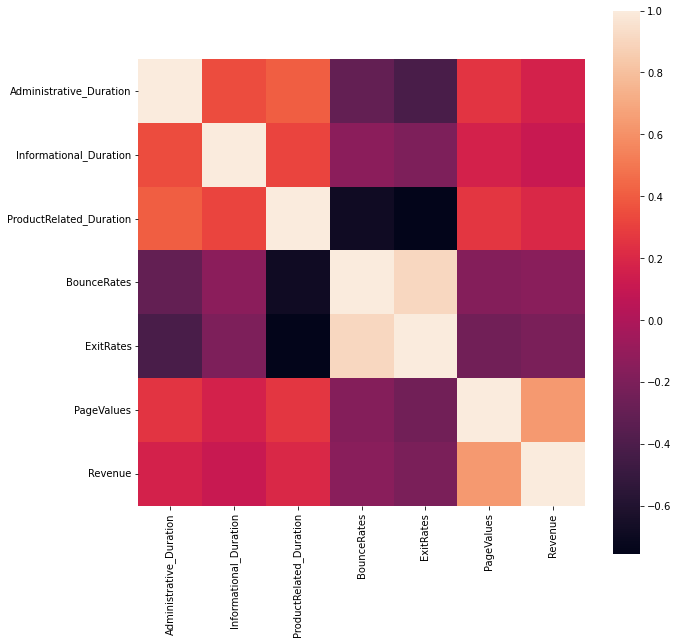

In [17]:
# Área de plotagem
plt.figure(figsize = (10,10))

# Matriz de Correlação 
sns.heatmap(df[['Administrative_Duration',
                'Informational_Duration',  
                'ProductRelated_Duration',
                'BounceRates', 
                'ExitRates', 
                'PageValues',
                'Revenue']].corr(), vmax = 1., square = True)

Visualização de gráficos de variáveis categóricas para analisar como a variável de destino é influenciada por elas.

<AxesSubplot:title={'center':'Venda ou Não'}, xlabel='Revenue', ylabel='count'>

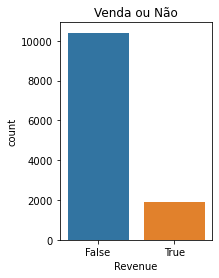

In [18]:
# Countplot Venda ou Não
plt.subplot(1,2,2)
plt.title("Venda ou Não")
sns.countplot(df['Revenue']) # a maioria de sessoes dessa website nao é realizada a compra

<AxesSubplot:xlabel='VisitorType', ylabel='count'>

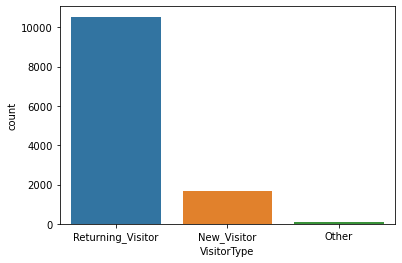

In [19]:
# Countplot Tipo de Visitante ( a maioria dos visitantes estao retornando, ou seja, voltaram ao site)
plt.xlabel("Tipo de Visitante")
sns.countplot(df['VisitorType'])

<AxesSubplot:xlabel='VisitorType'>

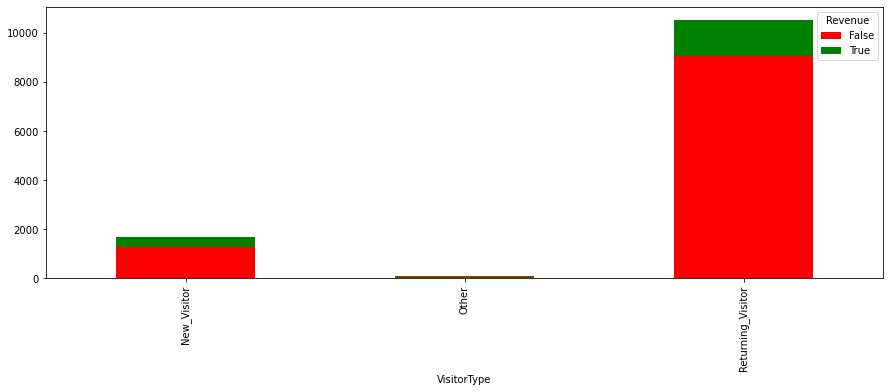

In [20]:
# Stacked Bar Tipo de Visitante x Revenue
pd.crosstab(df['VisitorType'], df['Revenue']).plot(kind = 'bar', 
                                                   stacked = True, 
                                                   figsize = (15, 5), 
                                                   color = ['red', 'green'])

#OBS: a quantidade de vendas é bem maior quando o cliente retorna ao site, tenta fazer a analise baseada na proporção para ter uma ideia melhor

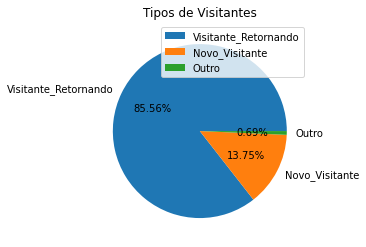

In [21]:
# Pie Chart Tipos de Visitantes
labels = ['Visitante_Retornando', 'Novo_Visitante', 'Outro']
plt.title("Tipos de Visitantes")
plt.pie(df['VisitorType'].value_counts(), labels = labels, autopct = '%.2f%%')
plt.legend()

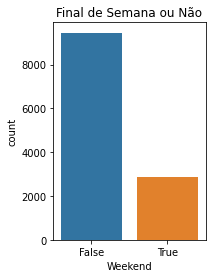

In [26]:
# Countplot Final de Semana ou Não
plt.subplot(1,2,1)
plt.title("Final de Semana ou Não")
sns.countplot(df['Weekend'])

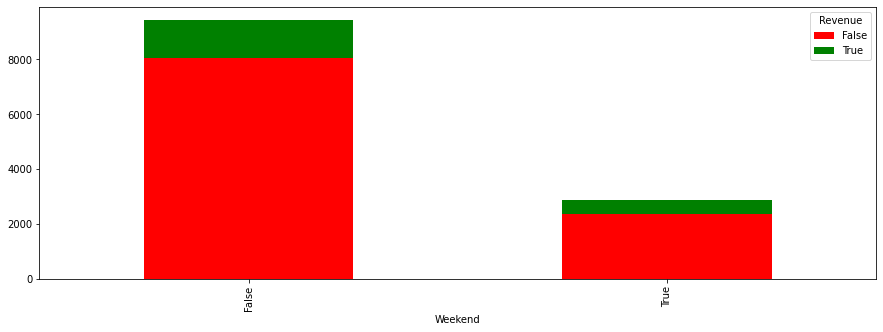

In [27]:
# Stacked Bar Final de Semana x Revenue
pd.crosstab(df['Weekend'], df['Revenue']).plot(kind = 'bar', 
                                               stacked = True, 
                                               figsize = (15, 5), 
                                               color = ['red', 'green'])

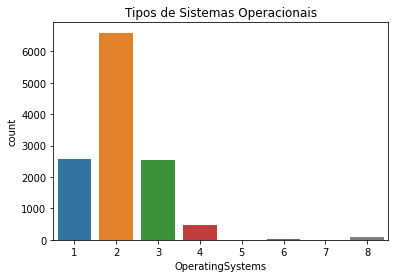

In [28]:
# Countplot Tipos de Sistemas Operacionais
#plt.figure(figsize = (15,6))
plt.title("Tipos de Sistemas Operacionais")
plt.xlabel("Sistema Operacional Usado")
sns.countplot(df['OperatingSystems'])

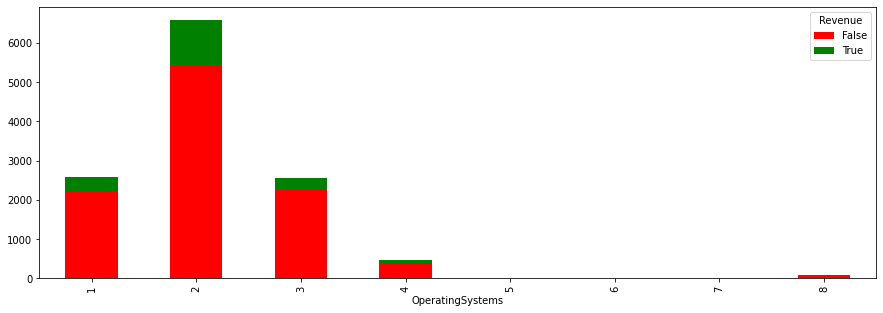

In [29]:
# Stacked Bar Tipo de SO x Revenue
pd.crosstab(df['OperatingSystems'], df['Revenue']).plot(kind = 'bar', 
                                                        stacked = True, 
                                                        figsize = (15, 5), 
                                                        color = ['red', 'green'])

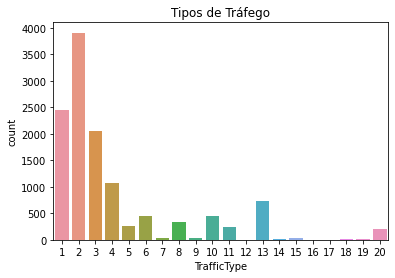

In [30]:
# Countplot Tipo de Tráfego
plt.title("Tipos de Tráfego")
plt.xlabel("Tipo de Tráfego")
sns.countplot(df['TrafficType'])

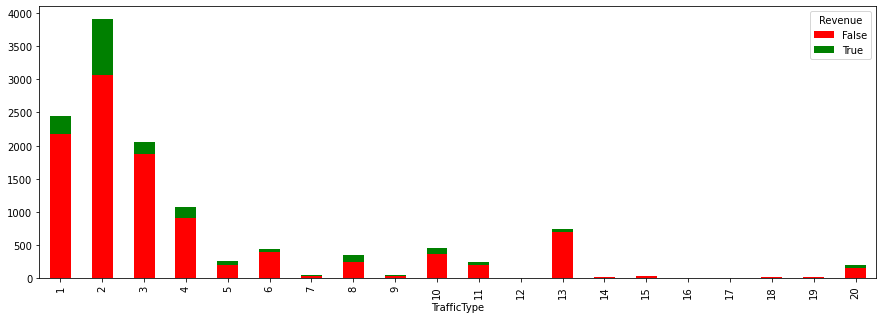

In [31]:
# Stacked Bar Tipos de Tráfego x Revenue
pd.crosstab(df['TrafficType'], df['Revenue']).plot(kind = 'bar', 
                                                   stacked = True, 
                                                   figsize = (15, 5), 
                                                   color = ['red', 'green'])

#OBS: confirmando que o tráfego 2 é o que mais vende também, seria interessante o pessoal de marketing investir mais nele 

## Pré-Processamento dos Dados

In [32]:
df_original.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [22]:
# Cria o encoder
lb = LabelEncoder()

# Aplica o encoder nas variáveis que estão com string
df_original['Month'] = lb.fit_transform(df_original['Month'])
df_original['VisitorType'] = lb.fit_transform(df_original['VisitorType'])

# Remove valores missing eventualmente gerados
df_original.dropna(inplace = True)

In [23]:
df_original.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,2,1,1,1,1,2,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,2,2,2,1,2,2,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,2,4,1,9,3,2,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,2,3,2,2,4,2,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,2,3,3,1,4,2,True,False


In [35]:
# Shape
df_original.shape

(12316, 18)

In [24]:
# Verificando se a variável resposta está balanceada
target_count = df_original.Revenue.value_counts()
target_count # logo da para ver que nao esta tao balanceada assim

False    10408
True      1908
Name: Revenue, dtype: int64

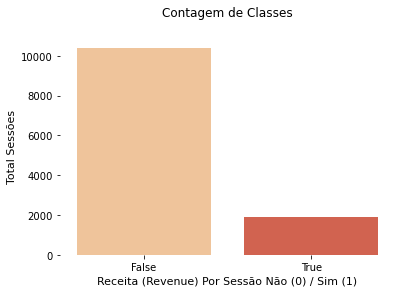

In [25]:
# Plot 
sns.countplot(df_original.Revenue, palette = "OrRd")
plt.box(False)
plt.xlabel('Receita (Revenue) Por Sessão Não (0) / Sim (1)', fontsize = 11)
plt.ylabel('Total Sessões', fontsize = 11)
plt.title('Contagem de Classes\n')
plt.show()

In [26]:
# Instala e importa o pacote imblearn
#!pip install -q imblearn ("-q" é para fazer a instalação silenciosa e nao aparecer nada no notebook)
import imblearn

In [39]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

numpy      1.18.2
sklearn    0.22.2
pandas     1.0.3
imblearn   0.6.2
matplotlib 3.2.1
seaborn    0.10.0
Data Science Academy


In [40]:
# Shape
df_original.shape

(12316, 18)

In [27]:
# Variáveis explicativas
df_original.iloc[:, 0:17].head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,2,1,1,1,1,2,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,2,2,2,1,2,2,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,2,4,1,9,3,2,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,2,3,2,2,4,2,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,2,3,3,1,4,2,True


In [42]:
# Variável Target
df_original.iloc[:, 17].head()

0    False
1    False
2    False
3    False
4    False
Name: Revenue, dtype: bool

Balanceamento de Classe - Oversampling

In [28]:
# Importa a função
from imblearn.over_sampling import SMOTE # para fazer o balanceamento

# Seed para reproduzir o mesmo resultado
seed = 100

# Separa X e y
X = df_original.iloc[:, 0:17]  
y = df_original.iloc[:, 17] 

# Cria o balanceador SMOTE
smote_bal = SMOTE(random_state = seed)

# Aplica o balanceador
X_res, y_res = smote_bal.fit_resample(X, y)

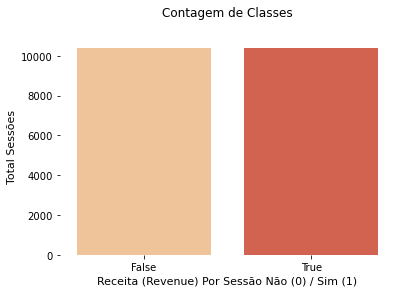

In [29]:
# Plot 
sns.countplot(y_res, palette = "OrRd")
plt.box(False)
plt.xlabel('Receita (Revenue) Por Sessão Não (0) / Sim (1)', fontsize = 11)
plt.ylabel('Total Sessões', fontsize = 11)
plt.title('Contagem de Classes\n')
plt.show()

In [30]:
# Shape dos dados originais
df_original.shape

(12316, 18)

In [31]:
# Shape dos dados reamostrados 
X_res.shape

(20816, 17)

In [32]:
# Shape dos dados reamostrados 
y_res.shape

(20816,)

In [33]:
# Ajustando X e y
X = X_res
y = y_res

In [34]:
# Divisão em Dados de Treino e Teste.
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.3, random_state = 42)

## Modelo SVM

### Modelo Base com Kernel Linear

In [35]:
# Cria o modelo
modelo_v1 = svm.SVC(kernel = 'linear') # SVC = Support Vector CLassifier

In [ ]:
# Treinamento
start = time.time()
modelo_v1.fit(X_treino, y_treino)
end = time.time()
print('Tempo de Treinamento do Modelo:', end - start)

In [52]:
# Previsões
previsoes_v1 = modelo_v1.predict(X_teste)

In [53]:
# Dicionário de métricas e metadados
SVM_dict_v1 = {'Modelo':'SVM',
               'Versão':'1',
               'Kernel':'Linear',
               'Precision':precision_score(previsoes_v1, y_teste),
               'Recall':recall_score(previsoes_v1, y_teste),
               'F1 Score':f1_score(previsoes_v1, y_teste),
               'Acurácia':accuracy_score(previsoes_v1, y_teste),
               'AUC':roc_auc_score(y_teste, previsoes_v1)} # aqui tem que inverter a ordem

In [54]:
# Print
print("Métricas em Teste:\n")
SVM_dict_v1

Métricas em Teste:



{'Modelo': 'SVM',
 'Versão': '1',
 'Kernel': 'Linear',
 'Precision': 0.8694550063371356,
 'Recall': 0.7988355167394469,
 'F1 Score': 0.832650584129874,
 'Acurácia': 0.8233787029623699,
 'AUC': 0.8228790085101022}

### Modelo com Kernel Linear e Dados Padronizados (Scaled)

In [55]:
# ***** Atenção *****
# O método nesta célula não deve ser usado, pois estaríamos aplicando o fit em teste e isso não é o ideal
# Aplicamos o fit somente nos dados de treino e aplicamos o transform nos dados de teste
# Padronização
# X_treino_scaled = StandardScaler().fit_transform(X_treino)
# X_teste_scaled = StandardScaler().fit_transform(X_teste)

In [56]:
# Agora sim, a forma ideal de aplicar a padronização em treino e teste
# Padronização
sc = StandardScaler()
X_treino_scaled = sc.fit_transform(X_treino)
X_teste_scaled = sc.transform(X_teste)

Obsevação:

Para impedir que as informações sobre a distribuição do conjunto de teste vazem em seu modelo, o ideal é aplicar a padronização em separado nos dados de treino e de teste, ajustando o redimensionador apenas aos dados de treinamento, padronizando então os conjuntos de treinamento e teste com esse redimensionador (exatamente como está na célula acima). Ao ajustar o redimensionador no conjunto de dados completo antes da divisão em treino e teste, informações sobre o conjunto de testes são usadas para transformar o conjunto de treinamento.

Conhecer a distribuição de todo o conjunto de dados pode influenciar como você detecta e processa outliers, bem como como você parametriza seu modelo. Embora os dados em si não sejam expostos, há informações sobre a distribuição dos dados. Como resultado, o desempenho do seu conjunto de testes não é uma estimativa real do desempenho em dados invisíveis.

Sempre aplique a padronização depois de fazer a divisão em treino e teste, exatamente como fizemos aqui. Usamos fit_transform() nos dados de treino e transform() nos dados de teste quando usamos o StandardScaler().

In [57]:
X_treino_scaled

array([[ 0.67023596,  0.00746589, -0.4556655 , ..., -0.50179946,
         0.54253778, -0.69426044],
       [-0.71405441, -0.53155654, -0.4556655 , ..., -0.77161458,
         0.54253778,  1.44038165],
       [ 0.9117153 , -0.18078072, -0.4556655 , ...,  0.57746102,
         0.54253778,  1.44038165],
       ...,
       [-0.21784301,  0.00977669,  1.83111142, ..., -0.50179946,
         0.54253778, -0.69426044],
       [-0.80989566, -0.53903796, -0.4556655 , ..., -0.50179946,
        -2.06175081, -0.69426044],
       [-0.37088559, -0.29288262,  0.58272764, ..., -0.50179946,
        -0.75960651, -0.69426044]])

In [58]:
X_teste_scaled

array([[-0.74974984, -0.52847418, -0.4556655 , ...,  0.57746102,
        -2.06175081,  1.44038165],
       [-0.80989566, -0.53903796, -0.4556655 , ..., -0.77161458,
         0.54253778,  1.44038165],
       [-0.80989566, -0.53903796, -0.4556655 , ..., -0.77161458,
         0.54253778,  1.44038165],
       ...,
       [-0.80989566, -0.53903796, -0.4556655 , ...,  0.57746102,
         0.54253778, -0.69426044],
       [ 1.03373541,  1.74922518, -0.4556655 , ..., -0.50179946,
         0.54253778,  1.44038165],
       [ 0.3044991 , -0.28747987,  1.09682136, ..., -0.50179946,
         0.54253778, -0.69426044]])

In [59]:
# Cria o modelo
modelo_v2 = svm.SVC(kernel = 'linear')

In [60]:
# Treinamento
start = time.time()
modelo_v2.fit(X_treino_scaled, y_treino)
end = time.time()
print('Tempo de Treinamento do Modelo:', end - start)

Tempo de Treinamento do Modelo: 6.130856990814209


In [61]:
# Previsões
previsoes_v2 = modelo_v2.predict(X_teste_scaled)

In [62]:
# Dicionário de métricas e metadados
SVM_dict_v2 = {'Modelo':'SVM',
               'Versão':'2',
               'Kernel':'Linear com Dados Padronizados',
               'Precision':precision_score(previsoes_v2, y_teste),
               'Recall':recall_score(previsoes_v2, y_teste),
               'F1 Score':f1_score(previsoes_v2, y_teste),
               'Acurácia':accuracy_score(previsoes_v2, y_teste),
               'AUC':roc_auc_score(y_teste, previsoes_v2)}

In [63]:
# Print
print("Métricas em Teste:\n")
SVM_dict_v2

Métricas em Teste:



{'Modelo': 'SVM',
 'Versão': '2',
 'Kernel': 'Linear com Dados Padronizados',
 'Precision': 0.7896070975918885,
 'Recall': 0.8909545942080801,
 'F1 Score': 0.8372249286074249,
 'Acurácia': 0.844835868694956,
 'AUC': 0.8454348210523379}

### Otimização de Hiperparâmetros com Grid Search e Kernel RBF

In [64]:
# Cria o modelo
modelo_v3 = svm.SVC(kernel = 'rbf')

# Valores para o grid
C_range = np.array([50., 100., 200.])
gamma_range = np.array([0.3*0.001,0.001,3*0.001])

# Grid de hiperparâmetros
svm_param_grid = dict(gamma = gamma_range, C = C_range)

# Grid Search
start = time.time()
modelo_v3_grid_search_rbf = GridSearchCV(modelo_v3, svm_param_grid, cv = 3) # 3 validações cruzadas

# Treinamento
modelo_v3_grid_search_rbf.fit(X_treino_scaled, y_treino) # ja usando os dados padronizados
end = time.time()
print('Tempo de Treinamento do Modelo com Grid Search:', end - start)

# Acurácia em Treino
print(f"Acurácia em Treinamento: {modelo_v3_grid_search_rbf.best_score_ :.2%}")
print("")
print(f"Hiperparâmetros Ideais: {modelo_v3_grid_search_rbf.best_params_}")

Tempo de Treinamento do Modelo com Grid Search: 72.94386911392212
Acurácia em Treinamento: 87.41%

Hiperparâmetros Ideais: {'C': 200.0, 'gamma': 0.003}


In [65]:
# Previsões
previsoes_v3 = modelo_v3_grid_search_rbf.predict(X_teste_scaled)

In [66]:
# Dicionário de métricas e metadados
SVM_dict_v3 = {'Modelo':'SVM',
               'Versão':'3',
               'Kernel':'RBF com Dados Padronizados',
               'Precision':precision_score(previsoes_v3, y_teste),
               'Recall':recall_score(previsoes_v3, y_teste),
               'F1 Score':f1_score(previsoes_v3, y_teste),
               'Acurácia':accuracy_score(previsoes_v3, y_teste),
               'AUC':roc_auc_score(y_teste, previsoes_v3)}

In [67]:
# Print
print("Métricas em Teste:\n")
SVM_dict_v3

Métricas em Teste:



{'Modelo': 'SVM',
 'Versão': '3',
 'Kernel': 'RBF com Dados Padronizados',
 'Precision': 0.8361850443599493,
 'Recall': 0.8957909029192125,
 'F1 Score': 0.8649623074401837,
 'Acurácia': 0.8680544435548438,
 'AUC': 0.8684000650741152}

### Otimização de Hiperparâmetros com Grid Search e Kernel Polinomial

In [68]:
# Cria o modelo
modelo_v4 = svm.SVC(kernel = 'poly')

# Valores para o grid
r_range =  np.array([0.5, 1])
gamma_range =  np.array([0.001, 0.01])
d_range = np.array([2,3, 4])

# Grid de hiperparâmetros
param_grid_poly = dict(gamma = gamma_range, degree = d_range, coef0 = r_range)

# Grid Search
start = time.time()
modelo_v4_grid_search_poly = GridSearchCV(modelo_v4, param_grid_poly, cv = 3)

# Treinamento
modelo_v4_grid_search_poly.fit(X_treino_scaled, y_treino)
end = time.time()
print('Tempo de Treinamento do Modelo com Grid Search:', end - start)

# Acurácia em Treino
print(f"Acurácia em Treinamento: {modelo_v4_grid_search_poly.best_score_ :.2%}")
print("")
print(f"Hiperparâmetros Ideais: {modelo_v4_grid_search_poly.best_params_}")

Tempo de Treinamento do Modelo com Grid Search: 67.9084620475769
Acurácia em Treinamento: 86.14%

Hiperparâmetros Ideais: {'coef0': 1.0, 'degree': 4, 'gamma': 0.01}


In [69]:
# Previsões
previsoes_v4 = modelo_v4_grid_search_poly.predict(X_teste_scaled)

In [70]:
# Dicionário de métricas e metadados
SVM_dict_v4 = {'Modelo':'SVM',
               'Versão':'4',
               'Kernel':'Polinomial com Dados Padronizados',
               'Precision':precision_score(previsoes_v4, y_teste),
               'Recall':recall_score(previsoes_v4, y_teste),
               'F1 Score':f1_score(previsoes_v4, y_teste),
               'Acurácia':accuracy_score(previsoes_v4, y_teste),
               'AUC':roc_auc_score(y_teste, previsoes_v4)}

In [71]:
# Print
print("Métricas em Teste:\n")
SVM_dict_v4

Métricas em Teste:



{'Modelo': 'SVM',
 'Versão': '4',
 'Kernel': 'Polinomial com Dados Padronizados',
 'Precision': 0.811787072243346,
 'Recall': 0.8902015288394719,
 'F1 Score': 0.8491879350348028,
 'Acurácia': 0.8542834267413931,
 'AUC': 0.8547442968856743}

In [72]:
# Concatena todos os dicionários em um dataframe do Pandas
resumo = pd.DataFrame({'SVM_dict_v1':pd.Series(SVM_dict_v1),
                       'SVM_dict_v2':pd.Series(SVM_dict_v2),
                       'SVM_dict_v3':pd.Series(SVM_dict_v3),
                       'SVM_dict_v4':pd.Series(SVM_dict_v4)})

In [73]:
# Print
resumo

,SVM_dict_v1,SVM_dict_v2,SVM_dict_v3,SVM_dict_v4
Modelo,SVM,SVM,SVM,SVM
Versão,1,2,3,4
Kernel,Linear,Linear com Dados Padronizados,RBF com Dados Padronizados,Polinomial com Dados Padronizados
Precision,0.869455,0.789607,0.836185,0.811787
Recall,0.798836,0.890955,0.895791,0.890202
F1 Score,0.832651,0.837225,0.864962,0.849188
Acurácia,0.823379,0.844836,0.868054,0.854283
AUC,0.822879,0.845435,0.8684,0.854744


### Fazendo Previsões com o Modelo Treinado

In [74]:
# Novo registro (1 linha, com varias colunas por isso precisamos do reshape)
novo_x = np.array([4.0, 5.56, 1.0, 3.78, 2.995, 6.00, 0.69, 0.70, 0.69, 0, 6, 1, 1, 3, 3, 2, False]).reshape(1, -1)

In [75]:
# Padronizando o registro
novo_x_scaled = StandardScaler().fit_transform(novo_x) # pois aprendeu com os dados padronizados

In [76]:
# Previsão
previsao_novo_x = modelo_v3_grid_search_rbf.predict(novo_x_scaled)

In [77]:
previsao_novo_x

array([ True])

# Fim